# LUAD CPTAC analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from msresist.figures.figure3 import plotR2YQ2Y, plotclustersIndividually, plotPCA
from msresist.figures.figure1 import pca_dfs, plotClustergram
from msresist.figures.figureM1 import FormatWhiteNames, PlotMissingnessDensity, PlotArtificialMissingnessError, PlotWinsByWeight, FindMatchingPeptides, PlotArtificialMissingnessWins, TumorType, TransformCPTACdataForRegression
from msresist.logistic_regression import plotClusterCoefficients, plotPredictionProbabilities, plotConfusionMatrix
from msresist.pre_processing import preprocessing, filter_NaNpeptides, MeanCenter, Log2T
from msresist.clustering import MassSpecClustering
from msresist.motifs import MapMotifs
from msresist.parameter_tuning import GridSearchCPTAC
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## 1. Import and Preprocess Data

In [4]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [5]:
X.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsGGGVS,NP_002577.2,PBX2,S146-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071547,-0.600298,0.172339,-1.761406,0.421872,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
2,AAAAAsTQAQQ,NP_001035540.1,MINDY2,S575-p,0.012034,-0.630863,-1.159479,-0.740044,0.107228,-0.016971,-0.023379,-0.481045,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83783,-0.993838,0.317079,...,0.031572,-0.554645,-0.033640,-1.268642,0.266790,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Compare White vs Broad Quantitation

### Import White data set and Find matching values in full CPTAC data set

Import White data set:

In [6]:
white = pd.read_csv("msresist/data/MS/CPTAC/03CPTAC_filtered_White.csv").iloc[:-1, :]

In [7]:
white = white[~white["Protein"].str.contains("HLA class I histocompatibility antigen, B")]
white = white[~white["Protein"].str.contains("HLA class I histocompatibility antigen, A")]
white = white[~white["Protein"].str.contains("Lamina-associated polypeptide 2")]

Extract gene names from full protein description:

In [8]:
white = white.set_index("Protein").drop("Uncharacterized protein FLJ45252 OS=Homo sapiens OX=9606 PE=2 SV=2").reset_index()
genes = FormatWhiteNames(white)
white = white.drop("Protein", axis=1)
white.insert(1, "Gene", genes)
white.index = range(white.shape[0])

number of proteins without gene name: 0


Process sequences to generate +/- 5 motifs:

In [9]:
white = MapMotifs(white, white.iloc[:, 1]).drop("Position", axis=1).iloc[:, :10]
white = MeanCenter(Log2T(white, list(white.columns[2:])), list(white.columns[2:]), mc_row=True, mc_col=False).sort_values(by="Sequence")

Find matching patients of CPTAC data set:

In [10]:
WhiteCols = ["C3N.02587", "C3N.02587.N", "C3L.00893", "C3L.00893.N", "C3N.01488", "C3N.01488.N", "C3N.01413", "C3N.01413.N"]
cols = [X.columns[0]] + [X.columns[2]] + WhiteCols
X_tmt3 = X[cols].dropna().sort_values(by="Sequence")

In [11]:
X_white = FindMatchingPeptides(X_tmt3, white, cols=cols)
X_white = X_white.set_index(np.arange(X_white.shape[0]))

Number of mismatches:  3672


Find matching peptides of White data set:

In [12]:
White_X = FindMatchingPeptides(white, X_white, cols=False)

Number of mismatches:  0


### Heatmaps

BROAD QUANTIFICATION

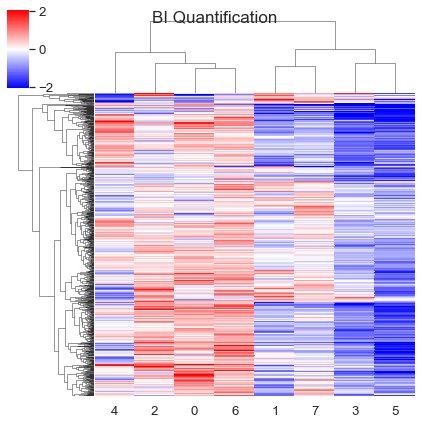

In [13]:
XW_ = X_white.set_index(["Gene"]).iloc[:, 1:]
XW_ = np.array(XW_, dtype="float64")
plotClustergram(XW_, "BI Quantification", np.max(np.abs(XW_)) * 0.3, figsize=(6,6))

WHITE QUANTIFICATION

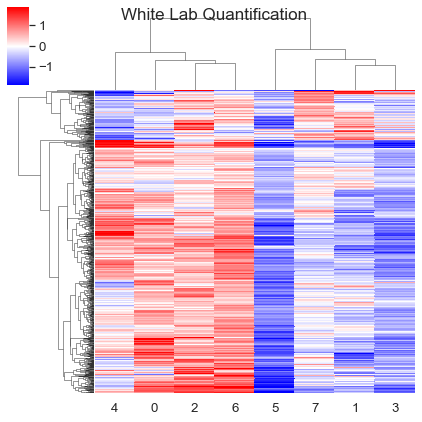

In [14]:
WX_ = White_X.set_index(["Gene"]).iloc[:, 1:]
WX_ = np.array(WX_, dtype="float64")
plotClustergram(WX_, "White Lab Quantification", np.max(np.abs(WX_)) * 0.6, figsize=(6,6))

### Model

#### BROAD

In [15]:
for i in range(2, X_white.shape[1]):
    X_white.iloc[:, i] = pd.to_numeric(X_white.iloc[:, i], errors="ignore")

In [16]:
Xd = X_white.iloc[:, 2:].T
Xi = X_white.iloc[:, :2]

In [17]:
distance_method = "PAM250"
ncl = 9
SeqWeight = 0.15

In [18]:
X_model = MassSpecClustering(Xi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Xd, "NA")

0 0.374797376876784
1 0.4790838482549753
2 0.5747248108125714
3 0.6242471714128142
4 0.6404180297910409


In [19]:
Xcenters = X_model.transform(Xd).T

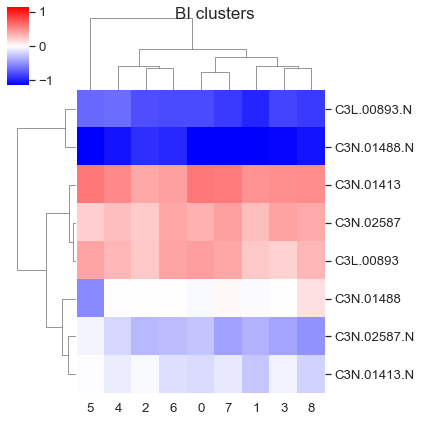

In [20]:
Xcenters.columns = Xd.index
plotClustergram(Xcenters.T, "BI clusters", max(np.max(np.abs(Xcenters))) * 0.9, figsize=(6,6), yticklabels=True)

#### Cluster Averages

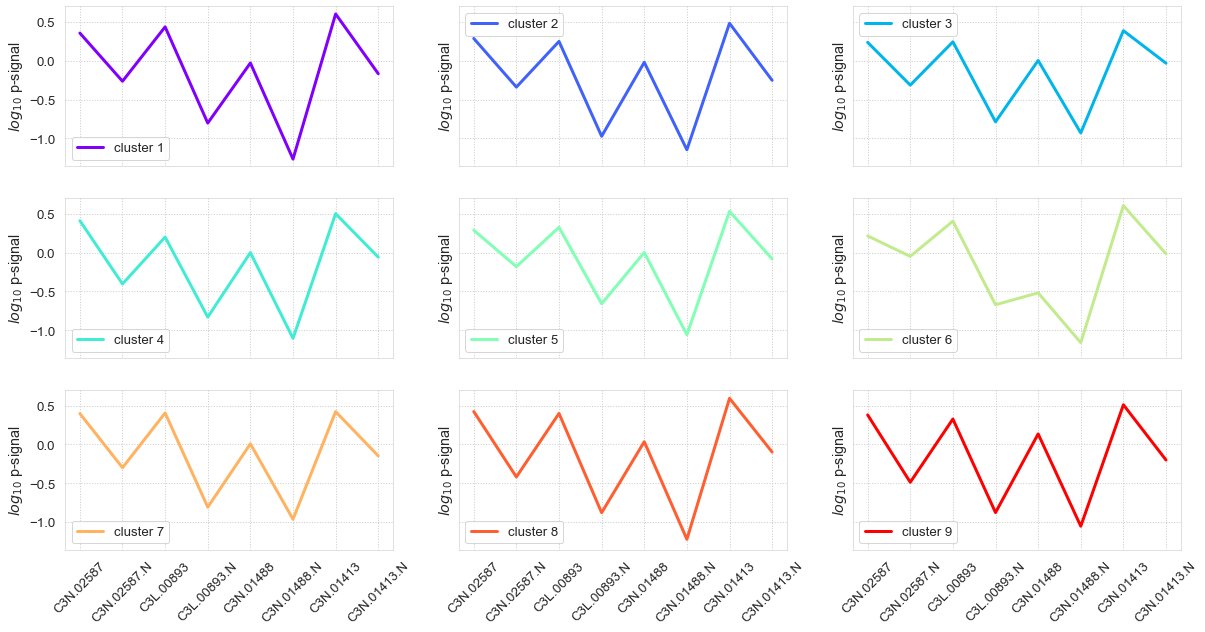

In [21]:
plotclustersIndividually(Xcenters, X_white.columns[2:], 3, 3)

#### PCA

In [22]:
Xcenters = Xcenters.T
Xcenters["Patient_ID"] = X_white.columns[2:]
Xcenters.iloc[:, :-1] = zscore(Xcenters.iloc[:, :-1], axis=1)
c=2

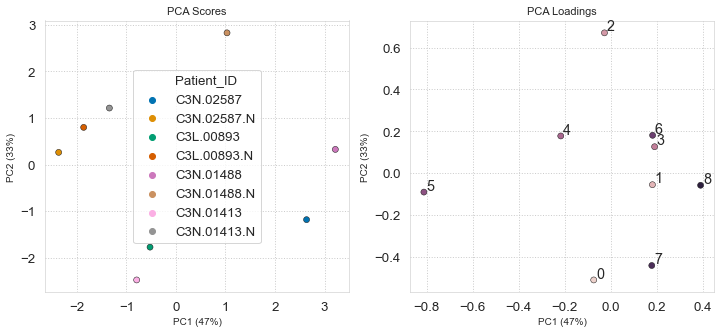

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plotPCA(ax, Xcenters, c, ["Patient_ID"], "Cluster", hue_scores="Patient_ID", hue_load="Cluster", legendOut=False)

#### WHITE Lab

In [24]:
for i in range(2, White_X.shape[1]):
    White_X.iloc[:, i] = pd.to_numeric(White_X.iloc[:, i], errors="ignore")

In [25]:
Wd = White_X.iloc[:, 2:].T
Wi = White_X.iloc[:, :2]

In [26]:
w_model = MassSpecClustering(Wi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Wd, "NA")

0 0.47850835692979105
1 0.42388169983541407
2 0.5498098724835362
3 0.6471616781242621
4 0.6924842411354274


In [27]:
Wcenters = w_model.transform(Wd).T

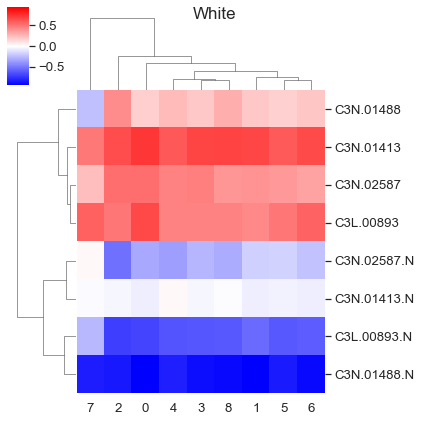

In [28]:
Wcenters.columns = Xd.index
plotClustergram(Wcenters.T, "White", max(np.max(np.abs(Wcenters))) * 0.9, figsize=(6,6), yticklabels=True)

#### Cluster Averages

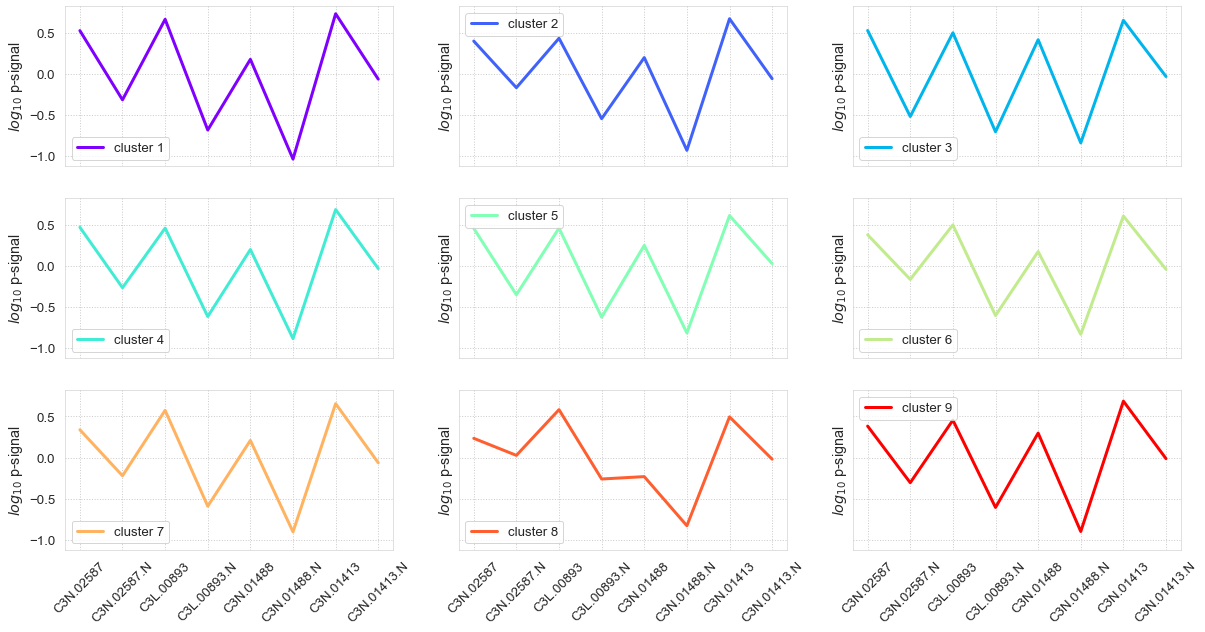

In [29]:
plotclustersIndividually(Wcenters, X_white.columns[2:], 3, 3)

#### PCA

In [30]:
Wcenters = Wcenters.T
Wcenters["Patient_ID"] = X_white.columns[2:]
Wcenters.iloc[:, :-1] = zscore(Wcenters.iloc[:, :-1], axis=1)
c=2

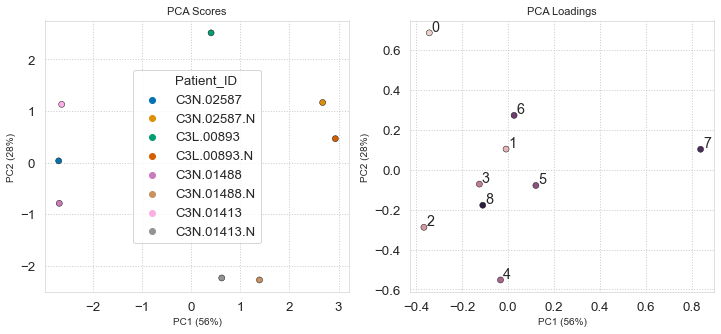

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plotPCA(ax, Wcenters, c, ["Patient_ID"], "Cluster", hue_scores="Patient_ID", hue_load="Cluster", legendOut=False)

## 3. Distribution of Missingness

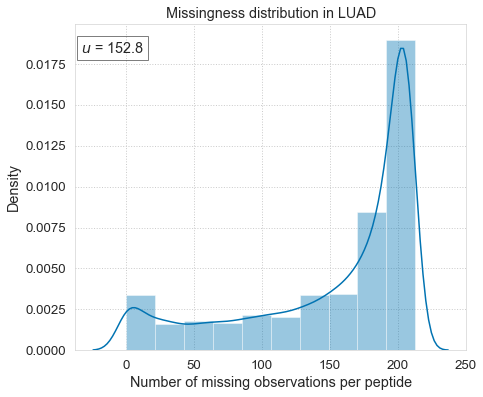

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
PlotMissingnessDensity(ax, d)

## 4. Artificial Missingness

Hypothesis: The sequence motif helps to correctly assign peptides to representative clusters, particularly at higher levels of missingness.

Approach: Introduce artificial missing data by leaving values out, and then seeing how well that values are represented by the corresponding clusters.

In [33]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000)

missing:  0.1
weight:  0
try: 1
0 0.987895545344851
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM, NaN responsibilities at iteration 0
1 0.9906323111366978
Re-initialize GMM, NaN responsibilities at iteration 1
2 0.9883727126716906
Re-initialize GMM clusters, empty cluster(s) at iteration 2
Re-initialize GMM, NaN responsibilities at iteration 2


KeyboardInterrupt: 

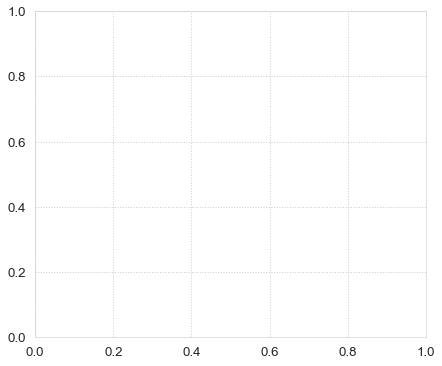

In [41]:
%%time
cd = filter_NaNpeptides(X, cut=1)
cd.index = np.arange(cd.shape[0])
nan_per = [0.1, 0.25, 0.5, 0.75, 0.9]
weights = [0, 0.3, 1]
ncl = 6

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x_ = PlotArtificialMissingnessError(ax, cd, weights, nan_per, "PAM250", ncl, max_n_iter=200)
# plt.savefig("Error_ArtificialMissingness.svg", bbox_inches='tight', format='svg', dpi=1200)

See how the wins behave in each fitted model across missingness % and per weight:

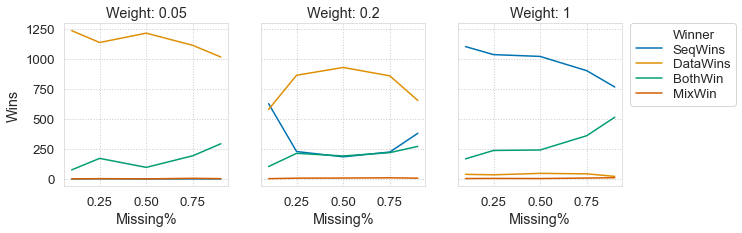

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
PlotArtificialMissingnessWins(ax, x_, weights)

## 5. Hyperparameter Tuning

Use center vs actual to test different hyperparameter combinations

In [1]:
%%time
cd = filter_NaNpeptides(X, cut=1)
X = GridSearchCPTAC(cd, "PAM250", 0.5, 200)

## 6. Run Model

Filter peptides based on a threshold of missingness

In [5]:
X_f = filter_NaNpeptides(X, cut=0.1)
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

Reduce data set:

In [38]:
# Reduce data set?
# npept = 2000
# d_r = d_f.iloc[:, :npept]
# i_r = i_f.iloc[:npept, :]

#Drop NaN?
# d = d.iloc[:8, :].dropna(axis=1)
# i = i.iloc[d.columns, :]

Run model:

In [53]:
%%time
distance_method = "PAM250"
ncl = 15
SeqWeight = 0.2

MSC = MassSpecClustering(i_f, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d_f, "NA")

In [50]:
MSC.wins_

(7338, 16605, 307, 1016)

Save model:

In [43]:
# with open('CPTACmodel_PAM250_W020_15CL', 'wb') as f:
#     pickle.dump([MSC], f)

Load if necessary:

In [41]:
with open('CPTACmodel_PAM250_W020_15CL', 'rb') as f:
    MSC = pickle.load(f)[0]

In [42]:
MSC.wins_

'SeqWins: 21823 DataWins: 1637 BothWin: 918 MixWin: 888'

### Hierarchical Clustering

In [45]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]
centers.iloc[:, :-1] = zscore(centers.iloc[:, :-1], axis=1)

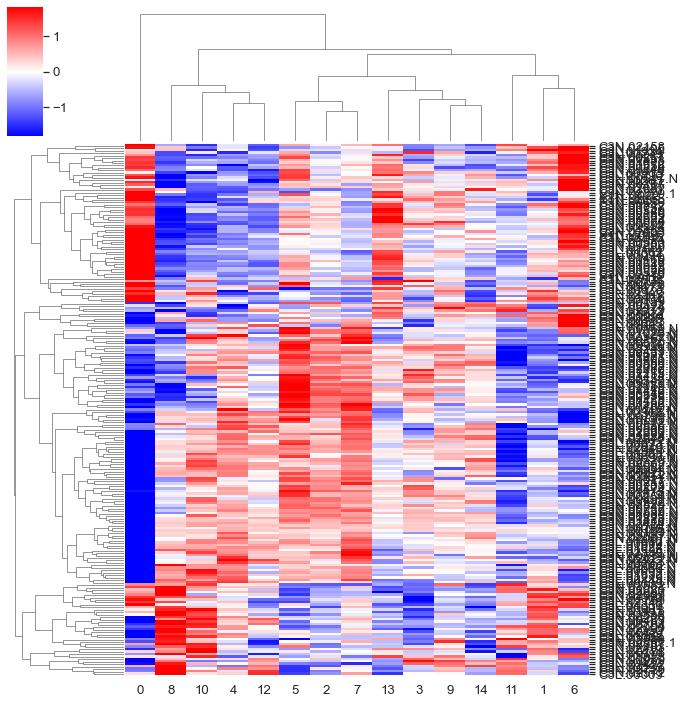

In [46]:
centers = centers.set_index(["Patient_ID"])
plotClustergram(centers, "", lim=max(np.max(np.abs(centers)) * 0.5), figsize=(10, 10), yticklabels=True)
centers = centers.reset_index()
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

### PCA Analysis

In [47]:
centers = TumorType(centers)
c = 2

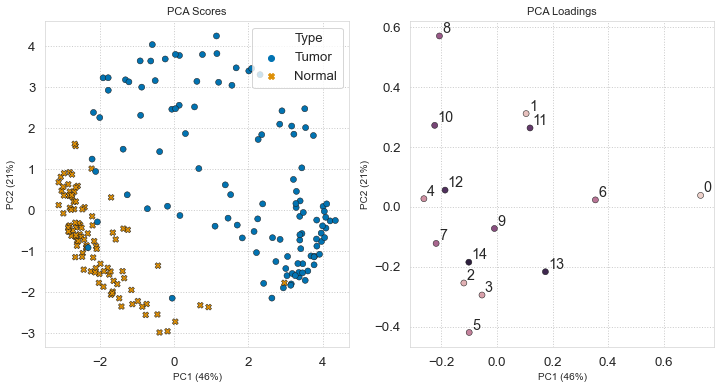

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plotPCA(ax, centers, c, ["Patient_ID", "Type"], "Cluster", hue_scores="Type", style_scores="Type", hue_load="Cluster")

## 7. Regression against Clinical Features

In [49]:
centers, y = TransformCPTACdataForRegression(MSC, d_f, list(X.columns[4:]))

### PLSR

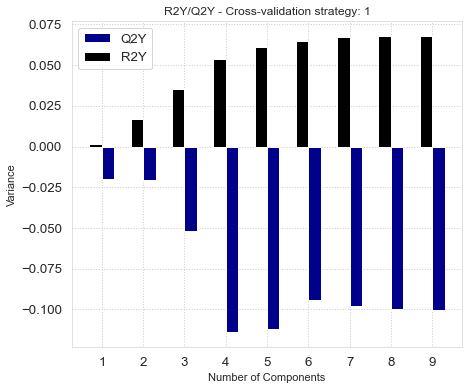

In [50]:
p10 = PLSRegression(n_components=2, scale=True)
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, p10, centers.iloc[:, 1:], y.iloc[:, 1], 1, 10)
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

### Logistic Regression

#### All samples (tumor and normal):

In [65]:
dd = centers.iloc[:, 1:]
yy = y.iloc[:, 1]

# lr = LogisticRegressionCV(cv=ncl, class_weight='balanced', Cs=200, solver="saga", penalty="l1").fit(dd, yy)
lr = LogisticRegressionCV(cv=ncl, class_weight='balanced', solver="saga", penalty="l1", Cs=5).fit(dd, yy)
y_pred = lr.predict(dd)
print(y_pred)

lr_score = lr.score(dd, yy)
print(lr_score)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1.]
0.6984924623115578


#### Coefficients

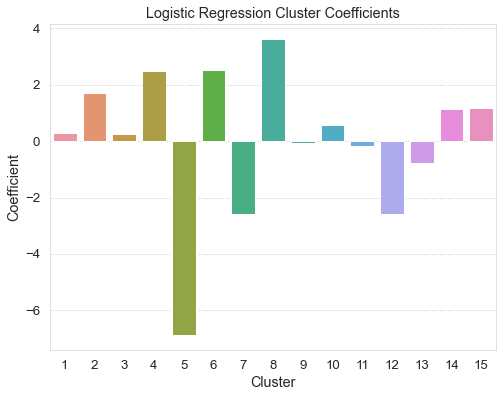

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)

Input, Output, and Classification results:
- Logit

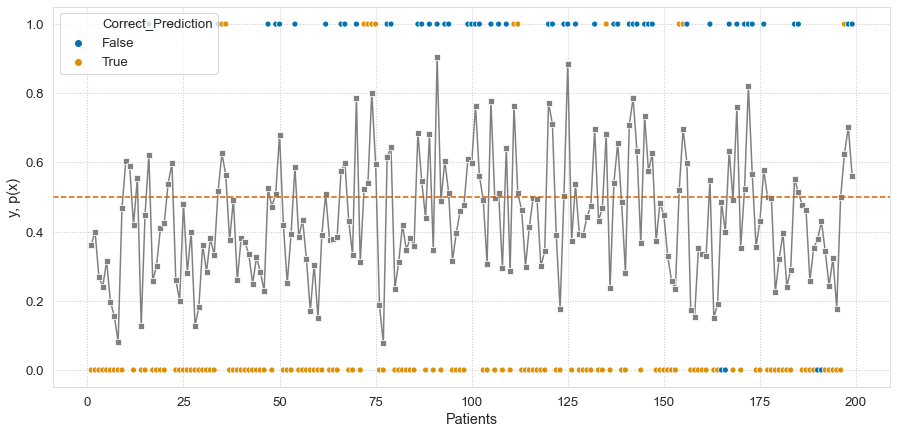

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plotPredictionProbabilities(ax, lr, y_pred, dd, yy)

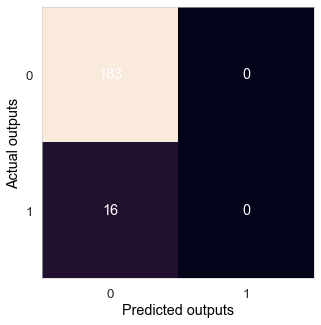

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, dd, yy)

#### Tumor only:

In [55]:
centers_T = centers[~centers["Patient_ID"].str.endswith(".N")].set_index("Patient_ID")
y_T = y[~y["Patient_ID"].str.endswith(".N")].set_index("Patient_ID").iloc[:, 0]

In [56]:
lr_T = LogisticRegressionCV(cv=ncl, class_weight='balanced', solver="saga", penalty="l1").fit(centers_T, y_T)
y_pred_T = lr_T.predict(centers_T)
print(y_pred_T)

lr_score_T = lr_T.score(centers_T, y_T)
print(lr_score_T)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0.]
0.7692307692307693


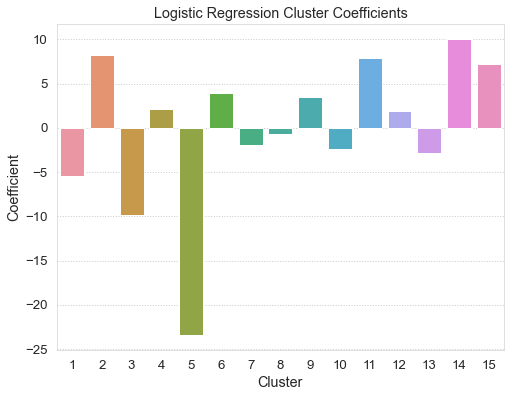

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr_T)

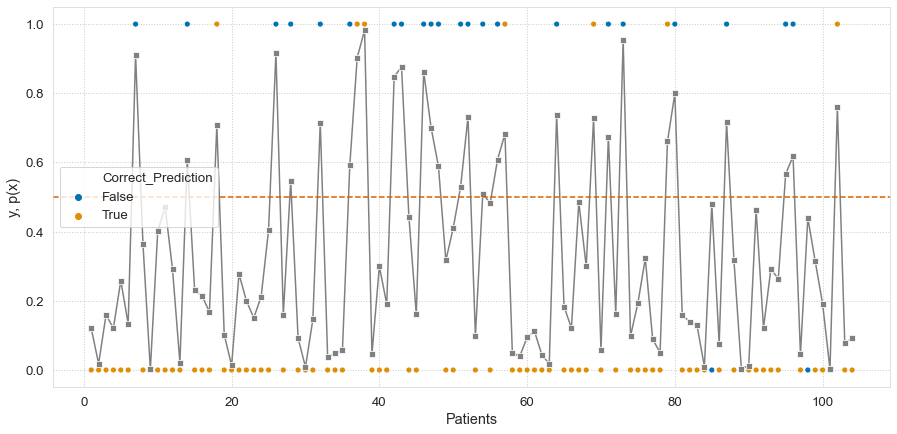

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plotPredictionProbabilities(ax, lr_T, y_pred_T, centers_T, y_T)

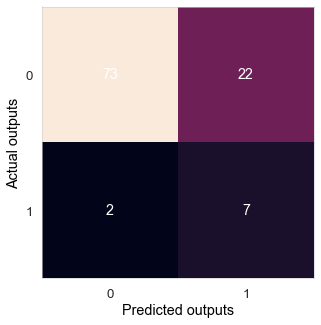

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr_T, centers_T, y_T)

#### Normal only:

In [60]:
centers_N = centers[centers["Patient_ID"].str.endswith(".N")].set_index("Patient_ID")
y_N = y[y["Patient_ID"].str.endswith(".N")].set_index("Patient_ID").iloc[:, 0]

In [61]:
lr_N = LogisticRegressionCV(cv=ncl, class_weight='balanced').fit(centers_N, y_N)
y_pred_N = lr.predict(centers_N)
print(y_pred_N)

lr_score_N = lr.score(centers_N, y_N)
print(lr_score_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.9263157894736842


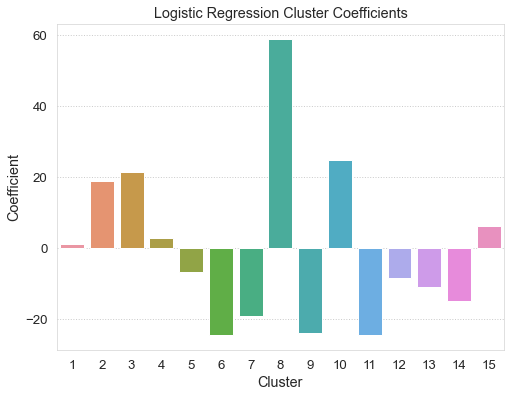

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr_N)

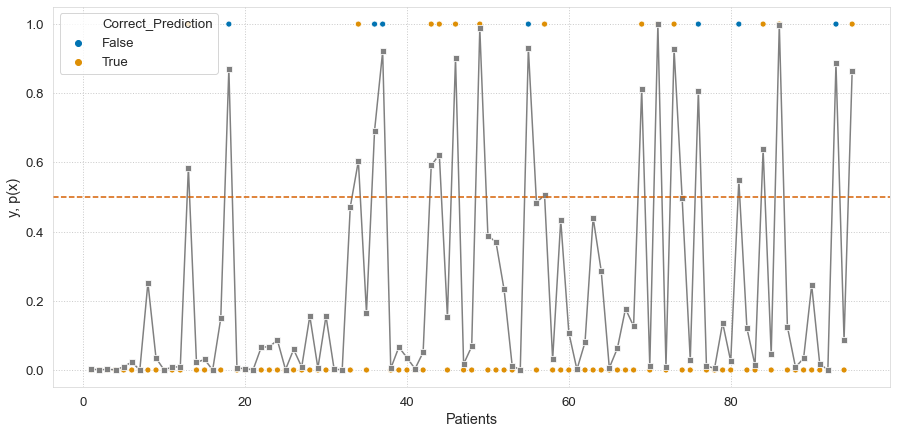

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plotPredictionProbabilities(ax, lr_N, y_pred_N, centers_N, y_N)

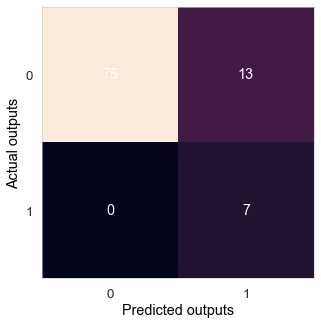

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr_N, centers_N, y_N)